# Projet kit datascience de Rémy ALLINE MS IA

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
URL_PAGE = "https://www.vendeeglobe.org/fr/glossaire"
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import datetime
import geopandas

import geopandas as gpd 
from geopandas import GeoDataFrame 
from shapely.geometry import LineString
import folium
from shapely.geometry import Point
from folium import IFrame
import random
import branca

import warnings
warnings.filterwarnings('ignore')

### recupération des données des voiliers et équipages

In [2]:
def get_soup_from_url(url):
    res = requests.get(url)
    soup = BeautifulSoup(res.content, 'html.parser')
    return soup
def get_boats(url):
    soup = get_soup_from_url(url)
    df=pd.DataFrame()
    prices = {}
    cpt=0
    list_of_series=[]
    boat=soup.find_all(class_="boats-list__popup-infos")
    for t in boat:
        title=t.find_all("h3")[0].text
        cpt+=1
        liste=[]
        for li in t.find_all("li"):
            liste.append(li.text.split(" : ",1))
        list_of_series.append(pd.Series(np.append(np.transpose(liste)[1],title),np.append(np.transpose(liste)[0],"Boat_name")))
        
    
    df=pd.DataFrame(list_of_series)
    
    return df

In [3]:
boats=get_boats(URL_PAGE)
boats["Boat_name"]=boats["Boat_name"].apply(lambda x : x.split(" - ")[-1].lower())
boats.head()

,Numéro de voile,Anciens noms du bateau,Architecte,Chantier,Date de lancement,Longueur,Largeur,Tirant d'eau,Déplacement (poids),Nombre de dérives,Hauteur mât,Voile quille,Surface de voiles au près,Surface de voiles au portant,Boat_name
0,FRA 56,"No Way Back, Vento di Sardegna",VPLP/Verdier,Persico Marine,01 Août 2015,"18,28 m","5,85 m","4,50 m",7 t,foils,29 m,monotype,320 m2,570 m2,art & fenêtres
1,FRA 49,"Gitana Eighty, Synerciel, Newrest-Matmut",Bruce Farr Design,Southern Ocean Marine (Nouvelle Zélande),08 Mars 2007,"18,28m","5,80m","4,50m",9t,2,28m,acier forgé,280 m2,560 m2,best western®
2,FRA72,"Famille Mary-Etamine du Lys, Initiatives Coeur...",Marc Lombard,MAG France,01 Mars 1998,"18,28m","5,54m","4,50m",9t,2,29 m,acier,260 m2,580 m2,4myplanet
3,17,Safran 2 - Des Voiles et Vous,Verdier - VPLP,CDK Technologies,12 Mars 2015,"18,28 m","5,80 m","4,50 m",8 t,foils,29 m,acier mécano soudé,310 m2,550 m2,maître coq iv
4,08,NaN,VPLP,CDK Technologies,18 Août 2018,"18,28 m","5,85 m","4,50 m",8t,foils,29 m,acier,320 m2,600 m2,charal


### recupération de tous les classements depuis le début de la course

In [4]:
all_classements=pd.DataFrame()
urls="https://www.vendeeglobe.org/fr/classement"
url_dowload="https://www.vendeeglobe.org/download-race-data/vendeeglobe_"
dates=[]
soup=get_soup_from_url(urls)
classements=soup.find_all(class_="form__input m--select onsubmit-rank")
date_bad=classements[0].find_all("option")[1]["value"]

classements=classements[0].find_all("option")

for i in range(1,len(classements)):

        d=classements[i]["value"]

#         print(url_dowload+d+".xlsx")
        skipper=pd.read_excel(url_dowload+d+".xlsx",header=[3,4])
        skipper.columns=["0","Rang","Nat / Voile","Skipper / Bateau", "Heure","Latitude","Longitude","Cap 30min","Vitesse 30min",\
                        "VMG 30min","Distance 30min","Cap last_report","Vitesse last_report","VMG last_report","Distance last_report","Cap 24h","Vitesse 24h","VMG 24h","Distance 24h"\
                        ,"DTF","DTL"]
        skipper.drop("0",axis=1,inplace=True)
        skipper.drop([33,34,35,36],inplace=True)
        skipper.dropna(inplace=True)
        skipper["Skipper"]=skipper["Skipper / Bateau"].apply(lambda x : x.split("\n")[0] )
        skipper["Boat_name"]=skipper["Skipper / Bateau"].apply(lambda x : x.split("\n")[1].lower() )

        skipper["Nat / Voile"]=skipper["Nat / Voile"].apply(lambda x : x.replace("\n", "") )
        skipper["Heure"]=skipper["Heure"].apply(lambda x : x.replace("\n", "") )
#         print(skipper[skipper["Skipper"]=="Jean Le Cam"]["DTF"])
        skipper["DTF"]=skipper["DTF"].apply(lambda x : x.split(" ",1)[0].replace(",","."))
        skipper["DTF"]=pd.to_numeric(skipper["DTF"],errors="coerce")
#         skipper["date"]=datetime.datetime(2020, 11, i,int(hours))
        skipper["date"]=datetime.datetime(int(d[:4]),int(d[4:6]),int(d[6:8]),int(d[9:11]))
        
        all_classements=pd.concat([all_classements,skipper])
all_classements.head()



,Rang,Nat / Voile,Skipper / Bateau,Heure,Latitude,Longitude,Cap 30min,Vitesse 30min,VMG 30min,Distance 30min,...,Distance last_report,Cap 24h,Vitesse 24h,VMG 24h,Distance 24h,DTF,DTL,Skipper,Boat_name,date
0,1,FRA 79,Charlie Dalin\nAPIVIA,11:30 FR,38°51.06'S,07°06.50'E,66°,22.1 kts,15.9 kts,11.0 nm,...,57.4 nm,68°,18.8 kts,14.3 kts,451.1 nm,18091.1,0.0 nm,Charlie Dalin,apivia,2020-11-29 11:00:00
1,2,FRA 59,Thomas Ruyant\nLinkedOut,10:30 FR-60min,38°15.32'S,00°25.72'E,51°,19.3 kts,9.4 kts,9.6 nm,...,36.9 nm,72°,19.1 kts,14.6 kts,457.4 nm,18396.8,305.7 nm,Thomas Ruyant,linkedout,2020-11-29 11:00:00
2,3,FRA 01,Jean Le Cam\nYes we Cam !,11:30 FR,37°54.01'S,00°28.03'W,126°,16.5 kts,16.1 kts,8.3 nm,...,47.3 nm,94°,15.8 kts,14.8 kts,379.4 nm,18444.0,353.0 nm,Jean Le Cam,yes we cam !,2020-11-29 11:00:00
3,4,FRA 85,Kevin Escoffier\nPRB,11:30 FR,38°28.30'S,00°59.28'W,49°,15.6 kts,7.1 kts,7.8 nm,...,41.5 nm,81°,18.6 kts,15.7 kts,445.5 nm,18453.8,362.7 nm,Kevin Escoffier,prb,2020-11-29 11:00:00
4,5,FRA 17,Yannick Bestaven\nMaître Coq IV,11:30 FR,37°22.70'S,01°10.17'W,55°,14.8 kts,7.8 kts,7.4 nm,...,54.0 nm,73°,19.2 kts,14.6 kts,460.9 nm,18487.0,395.9 nm,Yannick Bestaven,maître coq iv,2020-11-29 11:00:00


### Rapprochement des données des voiliers avec celles des classements.

In [5]:
df=all_classements.merge(boats, left_on='Boat_name', right_on='Boat_name')
df["foils"]=df["Nombre de dérives"].apply(lambda x : int(x=="foils"))
df.head()

,Rang,Nat / Voile,Skipper / Bateau,Heure,Latitude,Longitude,Cap 30min,Vitesse 30min,VMG 30min,Distance 30min,...,Longueur,Largeur,Tirant d'eau,Déplacement (poids),Nombre de dérives,Hauteur mât,Voile quille,Surface de voiles au près,Surface de voiles au portant,foils
0,1,FRA 79,Charlie Dalin\nAPIVIA,11:30 FR,38°51.06'S,07°06.50'E,66°,22.1 kts,15.9 kts,11.0 nm,...,"18,28 m","5,85 m","4,50 m",8 t,foils,29 m,acier,350 m2,560 m2,1
1,1,FRA 79,Charlie Dalin\nAPIVIA,08:30 FR,39°18.70'S,06°01.77'E,71°,17.1 kts,13.4 kts,8.5 nm,...,"18,28 m","5,85 m","4,50 m",8 t,foils,29 m,acier,350 m2,560 m2,1
2,1,FRA 79,Charlie Dalin\nAPIVIA,04:30 FR,39°42.66'S,04°35.79'E,65°,19.4 kts,14.0 kts,9.7 nm,...,"18,28 m","5,85 m","4,50 m",8 t,foils,29 m,acier,350 m2,560 m2,1
3,1,FRA 79,Charlie Dalin\nAPIVIA,21:30 FR,40°27.37'S,01°52.59'E,66°,19.8 kts,14.6 kts,9.9 nm,...,"18,28 m","5,85 m","4,50 m",8 t,foils,29 m,acier,350 m2,560 m2,1
4,1,FRA 79,Charlie Dalin\nAPIVIA,17:30 FR,40°55.01'S,00°15.51'E,78°,19.2 kts,16.6 kts,9.6 nm,...,"18,28 m","5,85 m","4,50 m",8 t,foils,29 m,acier,350 m2,560 m2,1


### Préparation des données

On voit que les données ne sont pas encore utilisable pour faire des analyse de corrélation appliqué des algorithmes de machine-learning.

En effet, les données ne sont pas dans des format numérique.

On va donc les préparer (on va passer les attribut qui le peuvent au un format numérique)

In [6]:
df_regression=pd.DataFrame(df[["Rang","VMG last_report","VMG 24h","VMG 30min","Tirant d'eau","Déplacement (poids)","Hauteur mât","Surface de voiles au près",\
                              "Surface de voiles au portant","Longueur","Largeur","foils"]])
cols=df_regression.columns
cols = cols[cols != "foils"]
for col in cols:
    df_regression[col]=df_regression[col].apply(lambda x : x.split(" ",1)[0].replace(",","."))
for i in ["Rang","VMG last_report","VMG 24h","VMG 30min","Tirant d'eau","Déplacement (poids)","Hauteur mât","Surface de voiles au près",\
                              "Surface de voiles au portant","Longueur","Largeur",]:
    df_regression[i]=pd.to_numeric(df_regression[i],errors="coerce")

# df_regression["Rang"]=df_regression["Rang"].apply(lambda x : abs(x-30))
df_regression.dropna(inplace=True)
df_regression.head()

,Rang,VMG last_report,VMG 24h,VMG 30min,Tirant d'eau,Déplacement (poids),Hauteur mât,Surface de voiles au près,Surface de voiles au portant,Longueur,Largeur,foils
0,1,12.7,14.3,15.9,4.5,8.0,29.0,350,560,18.28,5.85,1
1,1,13.7,14.4,13.4,4.5,8.0,29.0,350,560,18.28,5.85,1
2,1,14.7,14.4,14.0,4.5,8.0,29.0,350,560,18.28,5.85,1
3,1,15.2,14.5,14.6,4.5,8.0,29.0,350,560,18.28,5.85,1
4,1,16.6,14.1,16.6,4.5,8.0,29.0,350,560,18.28,5.85,1


On va essayer de voir parmis ces attributs lesquels ont le plus d'influence sur le rang des voiliers dans la course

Pour cela on va réaliser une régression linéaire et étudier le coefficient associé a chaque attribut.

Un coeficient élevé indique que cet attribut est plus présent chez les voilier qui on un rang élevé donc sont en mauvaise posture dans la course. Les coeficient plus faibles sont ceux qui impact positivement le classement.

### Normalisation pour regression lineaire

Avant de réaliser cette régression linéaire il est utile de normaliser nos variables.

In [7]:
df_scaled=pd.DataFrame(StandardScaler().fit(df_regression).transform(df_regression),columns=df_regression.columns)

In [8]:
train, test = train_test_split(df_regression, test_size=0.25)
y_train=pd.DataFrame(train["Rang"])
y_test=pd.DataFrame(test["Rang"])
X_train=pd.DataFrame(train.drop(columns=["Rang"]))
X_test=pd.DataFrame(test.drop(columns=["Rang"]))
X_train=StandardScaler().fit(X_train).transform(X_train)
X_test=StandardScaler().fit(X_test).transform(X_test)


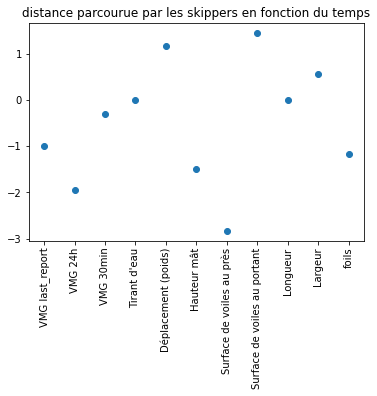

In [9]:
reg_ols = LinearRegression(fit_intercept=True).fit(X_train, y_train)
plt.figure()
plt.scatter(df_scaled.columns[1:],reg_ols.coef_[0])
plt.title("coefficients OLS")
plt.xticks(rotation=90)
plt.title("distance parcourue par les skippers en fonction du temps")

print()

on voit que les attributs les plus importants semblent être:
- la vitesse moyenne durant les 24 dernières heure
- la surface de voiles au près
- la presence d'un foil
- la taille du mat

### Matrice de correlation

on calcule ensuite la matrice de correlation entre les différentes variables:

un corrélation élevée montre que les deux variables sont correlées donc si la première est élevé la seconde aura tendance a l'être aussi

Pour le rang on cherche donc un corrélation inverse donc négative et proche de -1.

In [10]:
df_regression.corr()

,Rang,VMG last_report,VMG 24h,VMG 30min,Tirant d'eau,Déplacement (poids),Hauteur mât,Surface de voiles au près,Surface de voiles au portant,Longueur,Largeur,foils
Rang,1.000000e+00,-4.143836e-01,-4.591479e-01,-3.751236e-01,NaN,4.160085e-01,-2.973562e-01,-5.220448e-01,-4.951573e-03,-1.375760e-14,-2.089544e-01,-4.013274e-01
VMG last_report,-4.143836e-01,1.000000e+00,7.594173e-01,8.703307e-01,NaN,-2.179040e-01,1.210557e-01,1.997483e-01,4.144726e-02,5.737197e-16,1.088142e-01,1.620444e-01
VMG 24h,-4.591479e-01,7.594173e-01,1.000000e+00,6.397983e-01,NaN,-2.240989e-01,1.240300e-01,2.174082e-01,2.934564e-02,-1.161920e-15,1.173712e-01,1.760363e-01
VMG 30min,-3.751236e-01,8.703307e-01,6.397983e-01,1.000000e+00,NaN,-2.092193e-01,1.158989e-01,1.950275e-01,3.938393e-02,-5.116024e-15,1.109350e-01,1.624267e-01
Tirant d'eau,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Déplacement (poids),4.160085e-01,-2.179040e-01,-2.240989e-01,-2.092193e-01,NaN,1.000000e+00,-2.548377e-01,-4.028159e-01,-2.978911e-01,1.052047e-13,-1.277306e-02,-6.316311e-01
Hauteur mât,-2.973562e-01,1.210557e-01,1.240300e-01,1.158989e-01,NaN,-2.548377e-01,1.000000e+00,4.773497e-01,4.058785e-01,5.680012e-15,5.772908e-01,1.008235e-01
Surface de voiles au près,-5.220448e-01,1.997483e-01,2.174082e-01,1.950275e-01,NaN,-4.028159e-01,4.773497e-01,1.000000e+00,1.973429e-01,1.562562e-14,3.925079e-01,3.515416e-01
Surface de voiles au portant,-4.951573e-03,4.144726e-02,2.934564e-02,3.938393e-02,NaN,-2.978911e-01,4.058785e-01,1.973429e-01,1.000000e+00,-4.823528e-16,8.989348e-02,-6.422965e-03
Longueur,-1.375760e-14,5.737197e-16,-1.161920e-15,-5.116024e-15,NaN,1.052047e-13,5.680012e-15,1.562562e-14,-4.823528e-16,1.000000e+00,-9.128236e-14,1.484758e-15


on peut observer que les variables qui ont une corrélation la plus proche de -1 avec le rang sont:
-  VMG 24h
- les autres vitesse
- Surface de voiles au près
- foils
cela est cohérent avec les resultat de la regression linéaire
 
les variables les plus corrélées a la vitesse a 24h (autre que les vitesse) sont:
 - Surface de voiles au près
 - foils
 

### representation de l'avancement des voiliers

On va ensuite représenter l'avancement des voilier en fonction du temps 

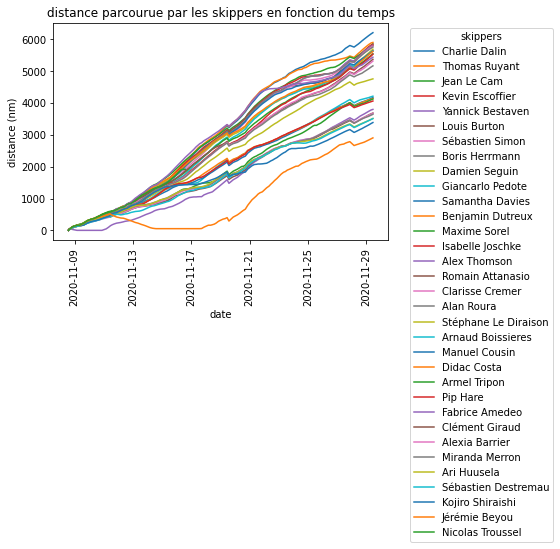

In [11]:
all_classements2=all_classements.copy()
all_classements2.set_index("date",inplace=True)

all_classements2["distance_parcourue"]=all_classements2["DTF"].max()-all_classements2["DTF"]
plt.figure()
for skip in all_classements2["Skipper"].unique():
    plt.plot(all_classements2[all_classements2["Skipper"]==skip].index.values,all_classements2[all_classements2["Skipper"]==skip]["distance_parcourue"],label=skip)
    
plt.legend(title='skippers', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=90)
plt.title("distance parcourue par les skippers en fonction du temps")
plt.xlabel("date")
plt.ylabel("distance (nm)")
print()

On represente ensuite le trajet en noeuds marin parcourue par chaque skipper d'après le rapport le plus récent

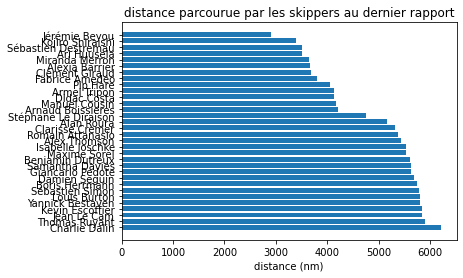

In [12]:
current_state=all_classements2.loc[all_classements2.index.values.max()]

plt.barh(current_state["Skipper"], current_state["distance_parcourue"], align='center')
plt.title("distance parcourue par les skippers au dernier rapport")
plt.xlabel("distance (nm)")

print()

j'ai ensuite fait une representation géographique des chemain parcourus par les différents skipper (on peut cliquer sur les nom des skipper dans la legend pour faire apparaitre/disparaitre leurs tracer) j'ai ajouter les couleures associer a chaques skipper en dessous

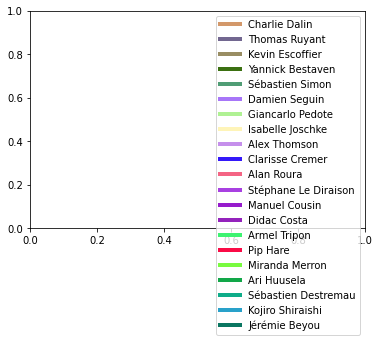

In [19]:
from matplotlib.lines import Line2D
from random import randint
color = []
n = 3
for i in range(len(df["Skipper"].unique())):
    color.append('#%06X' % randint(0, 0xFFFFFF))

f = folium.Figure(height = 400)
m = folium.Map([0, -19.675724], zoom_start = 2)
m.add_to(f)
idx=0
custom_lines=[]
liste_features=[folium.FeatureGroup("Lines") for x in range(len(df["Skipper"].unique()))]
for i in df["Skipper"].unique():
    df_geo=df[df["Skipper"]==i][["Latitude","Longitude","date"]]
    df_geo["Longitude"]=df_geo["Longitude"].apply(lambda x: (float(x[:2]) + float(x[3:5]) / 60. ) * (-1 if x[-1]=='W'  else 1))
    df_geo["Latitude"]=df_geo["Latitude"].apply(lambda x: (float(x[:2]) + float(x[3:5]) / 60. ) * (1 if x[-1]=='N'  else -1))
    df_geo['geometry2'] = df_geo.apply(lambda x: (x.Latitude , x.Longitude), axis=1)
#     child=folium.PolyLine(df_geo["geometry2"].values,color=color[idx], weight=0.5, opacity=1)
#     child.layer_name = i
    
    
    liste_features[idx] = folium.FeatureGroup(i)
    folium.PolyLine(df_geo["geometry2"].values,color=color[idx], weight=0.5, opacity=1).add_to(liste_features[idx])
    liste_features[idx].add_to(m)
    custom_lines.append(Line2D([0], [0], color=color[idx], lw=4))
    
    
    
    idx+=1
folium.LayerControl(collapsed=False).add_to(m)
plt.legend(custom_lines, df["Skipper"].unique())
m
